In [2]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from extractors import von_neumann, elias, universal_hash
from utils import compute_bias


import numpy as np
import matplotlib.pyplot as plt


In [3]:
import os
os.getcwd()


'c:\\Users\\ereci\\OneDrive\\Desktop\\QRANDOPT\\QRANDOPT\\notebooks'

In [4]:
import pytest


exit_code = pytest.main([
    "--maxfail=1",
    "--disable-warnings",
    "-q",
])
print(f"pytest exited with code {exit_code}")



no tests ran in 0.00s
pytest exited with code 5


In [5]:

raw_bits = np.random.choice([0,1], size=1000, p=[0.8,0.2]).tolist()
print(f"Raw bias = {compute_bias(raw_bits):.3f}, length = {len(raw_bits)}")


Raw bias = 0.305, length = 1000


In [6]:

import sys, os
from pathlib import Path


p = Path().resolve()


while not (p / "extractors").is_dir():
    if p.parent == p:
        raise RuntimeError("Could not find project root (no 'extractors/' folder).")
    p = p.parent

project_root = p  


os.chdir(project_root)


if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"✔️ Project root: {project_root}")
print(f"✔️ Working dir:   {os.getcwd()}")


✔️ Project root: C:\Users\ereci\OneDrive\Desktop\QRANDOPT\QRANDOPT
✔️ Working dir:   C:\Users\ereci\OneDrive\Desktop\QRANDOPT\QRANDOPT


In [7]:

import importlib, subprocess, sys

if importlib.util.find_spec("pytest") is None:
    print("Installing pytest…")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pytest"])
else:
    print("pytest already installed")


pytest already installed


Extractor     | Bias before | Bias after | Output len
------------- | ----------- | ---------- | ----------
         VN |       0.306 |      0.006 |        160
      Elias |       0.306 |      0.059 |        195
       Hash |       0.306 |      0.039 |        256
Maurer–Wolf |       0.306 |      0.056 |        496


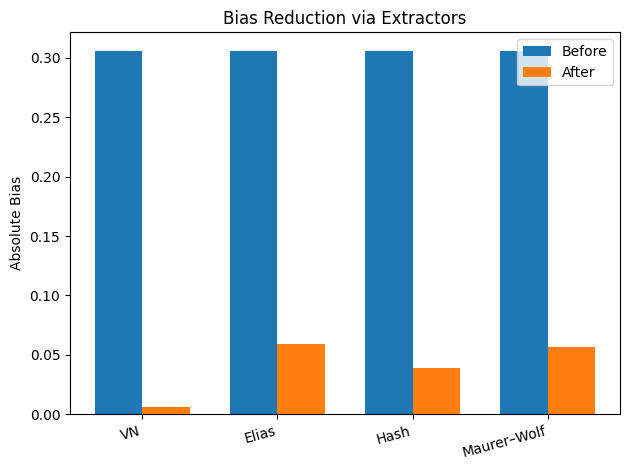

In [ ]:
"""
compare_extractors.py
Bias comparison and plotting for classical extractors plus Maurer–Wolf.
"""
import pytest
import numpy as np
import matplotlib.pyplot as plt

from extractors.von_neumann    import von_neumann
from extractors.elias          import elias
from extractors.universal_hash import universal_hash
from extractors.maurer_wolf    import maurer_wolf_extractor
from utils                     import compute_bias

def bits_to_bytes(bits):
    """Pack list of 0/1 bits into a bytes object (MSB-first)."""
   
    pad = (-len(bits)) % 8
    bits = bits + [0]*pad
    output = bytearray()
    for i in range(0, len(bits), 8):
        byte = 0
        for b in bits[i:i+8]:
            byte = (byte << 1) | b
        output.append(byte)
    return bytes(output)

def bytes_to_bits(b):
    """Unpack bytes into list of bits (MSB-first)."""
    bits = []
    for byte in b:
        for shift in range(7, -1, -1):
            bits.append((byte >> shift) & 1)
    return bits


raw_bits = np.random.choice([0, 1], size=1000, p=[0.8, 0.2]).tolist()

# Applying extractors & computing bias
results = {}
for name, fn in [
    ("VN",          von_neumann),
    ("Elias",       elias),
    ("Hash",        lambda bits: universal_hash(bits, seed="abc")),
    ("Maurer–Wolf", None)  
]:
    if name != "Maurer–Wolf":
        out = fn(raw_bits)
    else:
        # preparing inputs for the byte-based extractor
        raw_bytes = bits_to_bytes(raw_bits)
        seed      = b"abc"              
        out_len   = len(raw_bytes) // 2 
        extracted = maurer_wolf_extractor(raw_bytes, seed, out_len)
        out = bytes_to_bits(extracted)

    results[name] = (compute_bias(raw_bits), compute_bias(out), len(out))

# Print summary table
print("Extractor     | Bias before | Bias after | Output len")
print("------------- | ----------- | ---------- | ----------")
for name, (b0, b1, L) in results.items():
    print(f"{name:>11} | {b0:>11.3f} | {b1:>10.3f} | {L:>10}")

# Plot bias reduction
labels = list(results.keys())
before = [v[0] for v in results.values()]
after  = [v[1] for v in results.values()]
x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots()
ax.bar(x - w/2, before, width=w, label="Before")
ax.bar(x + w/2, after,  width=w, label="After")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15, ha="right")
ax.set_ylabel("Absolute Bias")
ax.set_title("Bias Reduction via Extractors")
ax.legend()
plt.tight_layout()
plt.show()




In [9]:

import pytest

# Explicitly pointing pytest at the tests directory:
exit_code = pytest.main([
    f"{project_root}/tests",
    "--maxfail=1",
    "--disable-warnings",
    "-q",
])
print(f"pytest exited with code {exit_code}")


......                                                                   [100%]
6 passed in 0.03s
pytest exited with code 0


In [10]:
import numpy as np



for N in [1000, 5000, 20000]:
    raw = np.random.choice([0,1], N, p=[0.8,0.2]).tolist()
    out = elias(raw)
    print(f"N={N:<5d} | before={compute_bias(raw):.3f} | after={compute_bias(out):.3f} | len={len(out)}")


N=1000  | before=0.325 | after=0.074 | len=195
N=5000  | before=0.301 | after=0.110 | len=694
N=20000 | before=0.302 | after=0.058 | len=2966


In [9]:
!pip install gym

     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     -------------------------------------- 721.7/721.7 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827740 sha256=10eb5e66c211816d695a60e75d812e8ee44e02b5b2d35b8e5d6eb7cfef8d14f7
  Stored in directory: c:\users\ereci\appdata\local\pip\cache\wheels\1c\77\9e\9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym


In [11]:
import numpy as np
import gym
from gym import spaces

from extractors.von_neumann      import von_neumann
from extractors.elias            import elias
from extractors.universal_hash   import universal_hash
from extractors.maurer_wolf      import maurer_wolf_extractor
from utils                       import compute_bias


In [17]:
#RL agent start
class ExtractorEnv(gym.Env):
    """
    Gym environment wrapping classical extractors.
    State: [bias, entropy] of the next window
    Action: choose extractor (0=VN,1=Elias,2=Hash,3=Maurer–Wolf)
    Reward: -|out_bias| + α*(len(out)/len(window))
    """
    metadata = {'render.modes': []}

    def __init__(self, raw_bits, window_size=256, alpha=0.1):
        super().__init__()
        self.raw_bits     = raw_bits
        self.window_size  = window_size
        self.alpha        = alpha
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(0.0, 1.0, (2,), np.float32)
        self.reset()

    def reset(self):
        self.pos   = 0
        self.state = None
        return self._next_state()

    def step(self, action):
        start, end = self.pos, min(self.pos + self.window_size, len(self.raw_bits))
        window     = self.raw_bits[start:end]

        if   action == 0: out = von_neumann(window)
        elif action == 1: out = elias(window)
        elif action == 2: out = universal_hash(window, seed="seed")
        else:
            rb = self._bits_to_bytes(window)
            ob = maurer_wolf_extractor(rb, seed=b"seed", output_len=len(rb)//2)
            out = self._bytes_to_bits(ob)

        raw_bias = compute_bias(window)
        out_bias = compute_bias(out)
        reward   = -abs(out_bias) + self.alpha * (len(out)/len(window))

        self.pos   = end
        done       = self.pos >= len(self.raw_bits)
        self.state = self._next_state()
        return self.state, reward, done, {'out_bits': out}

    def _next_state(self):
        end    = min(self.pos + self.window_size, len(self.raw_bits))
        window = self.raw_bits[self.pos:end]
        if not window:
            return np.array([0.,0.], dtype=np.float32)

        bias = compute_bias(window)
        p1   = sum(window)/len(window)
        p0   = 1-p1
        entropy = -(p0*np.log2(p0+1e-9) + p1*np.log2(p1+1e-9))
        return np.array([bias, entropy], dtype=np.float32)

    @staticmethod
    def _bits_to_bytes(bits):
        pad = (-len(bits)) % 8
        bits = bits + [0]*pad
        out  = bytearray()
        for i in range(0, len(bits), 8):
            byte = 0
            for b in bits[i:i+8]:
                byte = (byte<<1) | b
            out.append(byte)
        return bytes(out)

    @staticmethod
    def _bytes_to_bits(b):
        bits = []
        for byte in b:
            for shift in range(7,-1,-1):
                bits.append((byte>>shift)&1)
        return bits


class QLearningAgent:
    """Simple tabular Q‑learning agent."""
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env     = env
        self.alpha   = alpha
        self.gamma   = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((20,20, env.action_space.n))

    def discretize(self, state):
        return tuple((state*19).astype(int))

    def select_action(self, state):
        s = self.discretize(state)
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax(self.q_table[s]))

    def train(self, episodes=1000):
        for ep in range(episodes):
            state, done = self.env.reset(), False
            while not done:
                a, done_now = None, False
                action = self.select_action(state)
                next_state, reward, done_now, _ = self.env.step(action)
                s, ns = self.discretize(state), self.discretize(next_state)
                best_next = np.max(self.q_table[ns])
                idx = s + (action,)
                self.q_table[idx] += self.alpha * (reward + self.gamma*best_next - self.q_table[idx])
                state = next_state
                done = done_now


In [ ]:

raw = np.random.choice([0,1], size=20000, p=[0.8,0.2]).tolist()


env   = ExtractorEnv(raw, window_size=512, alpha=0.1)
agent = QLearningAgent(env, alpha=0.1, gamma=0.99, epsilon=0.2)


agent.train(episodes=2000)
print("Training complete.")


Training complete.


In [ ]:


# Resetting env and prepare storage
state, done = env.reset(), False
meta_out    = []


while not done:
    # Discretizing via the agent, then picking the best action
    s = agent.discretize(state)
    a = int(np.argmax(agent.q_table[s]))
    # Take the step
    state, _, done, info = env.step(a)
    meta_out.extend(info['out_bits'])

# Running classical extractors
results = {
    'Meta‑RL': meta_out,
    'VN':      von_neumann(raw),
    'Elias':   elias(raw),
    'Hash':    universal_hash(raw, seed="seed"),
}

# Maurer–Wolf
rb    = ExtractorEnv._bits_to_bytes(raw)
mw_bs = maurer_wolf_extractor(rb, seed=b"seed", output_len=len(rb)//2)
results['MW'] = ExtractorEnv._bytes_to_bits(mw_bs)

# Building a DataFrame of bias and output length
import pandas as pd
data = []
for name, out in results.items():
    data.append({
        'Extractor': name,
        'Bias':      compute_bias(out),
        'OutLen':    len(out)
    })
df = pd.DataFrame(data).set_index('Extractor')

# Displaying the comparison
df


,Bias,OutLen
Extractor,,
Meta‑RL,0.003320,10240
VN,0.004120,3277
Elias,0.082199,3011
Hash,0.015625,256
MW,0.001100,10000


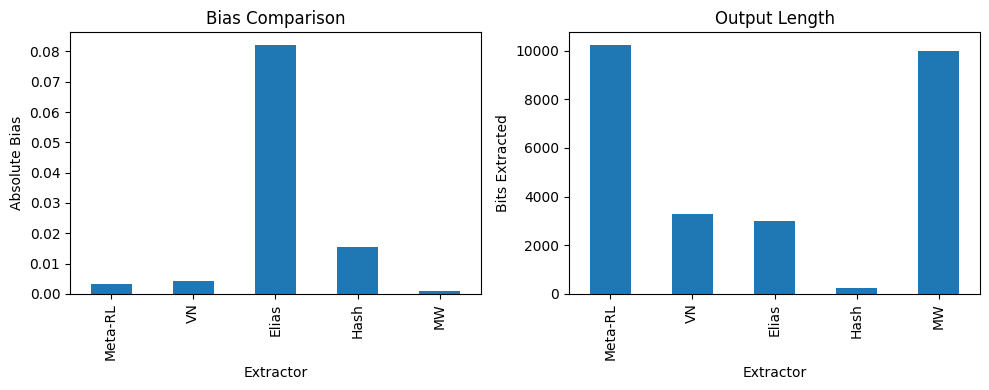

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(10,4))


df['Bias'].plot.bar(ax=axes[0], title='Bias Comparison')
axes[0].set_ylabel('Absolute Bias')

# Output Length
df['OutLen'].plot.bar(ax=axes[1], title='Output Length')
axes[1].set_ylabel('Bits Extracted')

plt.tight_layout()
plt.show()


In [ ]:

!pip install nistrng


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for nistrng: filename=nistrng-1.2.3-py3-none-any.whl size=38149 sha256=c3f669a392d417a2d1b001a66d35905eda919f22ef7d581ac0e446e0618cb9b3
  Stored in directory: c:\users\ereci\appdata\local\pip\cache\wheels\46\a2\c9\b753ddd50c60323c31569907f4bee42190a7f3dcea7a10eab4
Successfully built nistrng


In [ ]:
# Pure‑Python SP 800‑22 via nistrng 

import numpy as np
import pandas as pd
from nistrng import (
    SP800_22R1A_BATTERY,
    check_eligibility_all_battery,
    run_all_battery
)


binary_sequence = np.array(raw, dtype=np.int8)   


eligible = check_eligibility_all_battery(
    binary_sequence,
    SP800_22R1A_BATTERY
)


results = run_all_battery(
    binary_sequence,
    eligible,
    False
)

# Building a DataFrame of p‑values, pass/fail, and timing
rows = []
for result_obj, elapsed_ms in results:
    rows.append({
        "Test":     result_obj.name,
        "p_value":  result_obj.score,
        "pass":     result_obj.passed,
        "time_ms":  elapsed_ms
    })

df_nist = pd.DataFrame(rows).set_index("Test")
df_nist


c:\Users\ereci\anaconda3\envs\qrng311\Lib\site-packages\nistrng\sp800_22r1a\test_cumulative_sums.py:55: RuntimeWarning: overflow encountered in scalar absolute
  forward_max = max(abs(forward_sum), forward_max)
c:\Users\ereci\anaconda3\envs\qrng311\Lib\site-packages\nistrng\sp800_22r1a\test_cumulative_sums.py:53: RuntimeWarning: overflow encountered in scalar add
  forward_sum += bits_copy[i]
c:\Users\ereci\anaconda3\envs\qrng311\Lib\site-packages\nistrng\sp800_22r1a\test_cumulative_sums.py:56: RuntimeWarning: overflow encountered in scalar absolute
  backward_max = max(abs(backward_sum), backward_max)
c:\Users\ereci\anaconda3\envs\qrng311\Lib\site-packages\nistrng\sp800_22r1a\test_cumulative_sums.py:54: RuntimeWarning: overflow encountered in scalar add
  backward_sum += bits_copy[bits_copy.size - 1 - i]


,p_value,pass,time_ms
Test,,,
Monobit,0.000000e+00,False,0
Frequency Within Block,0.000000e+00,False,0
Longest Run Ones In A Block,7.923883e-74,False,4
Discrete Fourier Transform,1.890696e-157,False,1
Non Overlapping Template Matching,0.000000e+00,False,28
Serial,0.000000e+00,False,374
Approximate Entropy,0.000000e+00,False,179
Cumulative Sums,7.242412e-01,True,21
Random Excursion,6.302130e-01,False,50


In [ ]:
#  Comparing Pass‐Rates for Each Extractor 
import numpy as np
import pandas as pd
from nistrng import (
    SP800_22R1A_BATTERY,
    check_eligibility_all_battery,
    run_all_battery
)

def pass_rate(bits):
    seq = np.array(bits, dtype=np.int8)
    eligible = check_eligibility_all_battery(seq, SP800_22R1A_BATTERY)
    results = run_all_battery(seq, eligible, False)
    total = len(results)
    passed = sum(1 for res, _ in results if res.passed)
    return passed, total

# Building the streams dict (reuse raw, meta_out, etc.)
streams = {
    'Raw':     raw,
    'VN':      von_neumann(raw_bits),
    'Elias':   elias(raw_bits),
    'Hash':    universal_hash(raw_bits, seed="seed"),
    'MW':      ExtractorEnv._bytes_to_bits(
                   maurer_wolf_extractor(bits_to_bytes(raw_bits),
                                        seed=b"seed",
                                        output_len=len(raw_bits)//2)
               ),
    'Meta‑RL': meta_out
}

# Computing pass‐rates
data = []
for name, bits in streams.items():
    p, n = pass_rate(bits)
    data.append({'Extractor': name,
                 'Passed':    p,
                 'Total':     n,
                 'PassRate':  p/n})

df_rates = pd.DataFrame(data).set_index('Extractor')
df_rates


c:\Users\ereci\anaconda3\envs\qrng311\Lib\site-packages\nistrng\sp800_22r1a\test_cumulative_sums.py:55: RuntimeWarning: overflow encountered in scalar absolute
  forward_max = max(abs(forward_sum), forward_max)
c:\Users\ereci\anaconda3\envs\qrng311\Lib\site-packages\nistrng\sp800_22r1a\test_cumulative_sums.py:53: RuntimeWarning: overflow encountered in scalar add
  forward_sum += bits_copy[i]
c:\Users\ereci\anaconda3\envs\qrng311\Lib\site-packages\nistrng\sp800_22r1a\test_cumulative_sums.py:56: RuntimeWarning: overflow encountered in scalar absolute
  backward_max = max(abs(backward_sum), backward_max)
c:\Users\ereci\anaconda3\envs\qrng311\Lib\site-packages\nistrng\sp800_22r1a\test_cumulative_sums.py:54: RuntimeWarning: overflow encountered in scalar add
  backward_sum += bits_copy[bits_copy.size - 1 - i]


,Passed,Total,PassRate
Extractor,,,
Raw,2,10,0.200000
VN,9,11,0.818182
Elias,9,11,0.818182
Hash,10,11,0.909091
MW,10,11,0.909091
Meta‑RL,10,11,0.909091


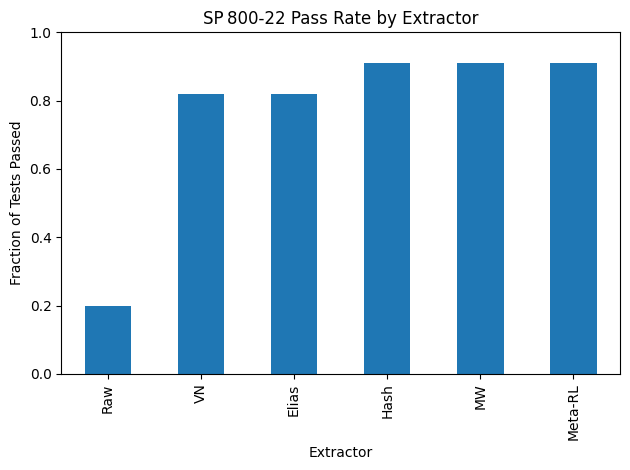

In [39]:
ax = df_rates['PassRate'].plot.bar(
    title='SP 800‑22 Pass Rate by Extractor', ylim=(0,1)
)
ax.set_ylabel('Fraction of Tests Passed')
plt.tight_layout()
plt.show()
